In [8]:
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('../py_scripts/Lyrics/')
from lyrics_preprocessing import *
from lyrics_sentiment_emotion_morals_annotations import *
from lyrics_sentiment_emotion_morals_annotations import *
from py_lex import EmoLex # https://github.com/dropofwill/py-lex
import moralstrength
from moralstrength.moralstrength import estimate_morals
from moralstrength import lexicon_use
lexicon_use.select_version("latest")

# Lyrics annotation with Sentiment (VADER), Emotion  (NRC) and MFT Scores (MoralStrength)

#### 1. Read the dataset:
Here we have the initial dataset that contains up to 5 song for each artist/band including **original lyrics**, **cleaned lyrics** (for cleaning use clean_lyrics method from lyrics_processing.py) and the **detected language column** (the language detection can be implemented by running lyrics_spacy_language_detection.py).
The data that we use here is cleaned based on Spotify track ids and number of words in lyrics. Also this dataset includes all the spotify low and high level features.

In [104]:
artist_lyrics_audio_dt = pd.read_csv('../Data/English_artist_5_tracks_with_lyrics_and_sp_features.csv')
print(artist_lyrics_audio_dt.shape)
artist_lyrics_audio_dt.head(3)

(30820, 126)


,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,word_counts,timbre_1_mean,...,track_duration,track_popularity,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,inital_songs_no
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...",409,50.619782,...,200400.0,71.0,0.03100,0.610,0.926,0.001200,0.0821,0.0479,0.861,9
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...",292,50.762770,...,192427.0,68.0,0.04070,0.636,0.873,0.000001,0.0372,0.0710,0.908,9
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...",315,51.466914,...,209400.0,66.0,0.00211,0.687,0.918,0.000013,0.3440,0.0392,0.747,9


In [105]:
artist_lyrics_audio_dt.isna().sum()

Artist                 0
Artist_cleaned_name    0
track_title            0
track_spotify_id       0
original_lyrics        0
                      ..
instrumentalness       0
liveness               0
speechiness            0
valence                0
inital_songs_no        0
Length: 126, dtype: int64

<AxesSubplot:ylabel='Frequency'>

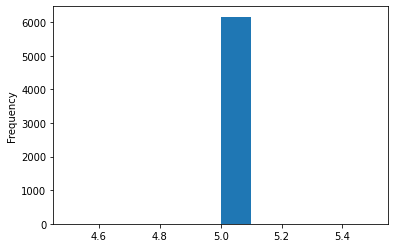

In [107]:
artist_lyrics_audio_dt.Artist_cleaned_name.value_counts().plot(kind ='hist')

In [108]:
print('Initial number of the artists is: ' + str(len(artist_lyrics_audio_dt.Artist.unique())))

Initial number of the artists is: 6164


In [109]:
artist_lyrics_audio_dt.lang_detect_spacy.value_counts()

en    30820
Name: lang_detect_spacy, dtype: int64

#### 5. Lyrics sentiment annotation with VADER lexicon:
For Vader, we don't need to lemmatize or tokenize the text. Also vader is key and punctuation sensitive.

In [110]:
artist_lyrics_audio_dt = apply_vader_sentiment(artist_lyrics_audio_dt)

In [111]:
artist_lyrics_audio_dt.head(3)

,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,word_counts,timbre_1_mean,...,energy,instrumentalness,liveness,speechiness,valence,inital_songs_no,vader_neg,vader_neu,vader_pos,vader_comp
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...",409,50.619782,...,0.926,0.001200,0.0821,0.0479,0.861,9,0.083,0.746,0.171,0.9887
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...",292,50.762770,...,0.873,0.000001,0.0372,0.0710,0.908,9,0.083,0.728,0.189,0.9887
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...",315,51.466914,...,0.918,0.000013,0.3440,0.0392,0.747,9,0.180,0.747,0.073,-0.9927


#### 6. Lyrics preprocessing: lemmatization and stopwords
For NRC emotion lexicon and MoralStrength lexion, we lemmatize the lyrics and also remove the stopwords. 

*6.1. Lemmatization and stopwords:*

In [69]:
lyrics_spacy_lemmas = spacy_lematization(artist_lyrics_audio_dt.cleaned_lyrics.str.lower())

In [113]:
lyrics_spacy_lemmas, lemma_counts = remove_stop_words(lyrics_spacy_lemmas)
artist_lyrics_audio_dt['lemmas'] = lyrics_spacy_lemmas   
artist_lyrics_audio_dt['lemma_counts'] = lemma_counts    

In [115]:
artist_lyrics_audio_dt.lemma_counts.describe()

count    30820.000000
mean       109.379267
std         64.568142
min          5.000000
25%         68.000000
50%         95.000000
75%        131.000000
max        855.000000
Name: lemma_counts, dtype: float64

In [116]:
len(lyrics_spacy_lemmas)

30820

We save lemmas in a json file, so we don't need to lemmatize the lyrics everytime as it is a process that takes a bit of time:

In [81]:
# with open('../Data/en_5_tracks_lyrics_lemmas', "w") as f:
#     json.dump(lyrics_spacy_lemmas, f)

If we want to read the lemmas, we use the command below: 

In [112]:
# with open('../Data/en_5_tracks_lyrics_lemmas') as f:
#     lyrics_spacy_lemmas = json.load(f)

#### 7. NRC lyrics word emotion annotation:
for using the word emotion annotation lexicon, please download the lexion from the offical page: http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm, and then add it to your prefered path as I did below:

In [117]:
en_lexicon = EmoLex("../../../../../../../EECS-DameMusicData/NRC-Suite-of-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")

In [118]:
artist_lyrics_audio_dt = apply_nrc_sentiment_emo(artist_lyrics_audio_dt, 
                                              en_lexicon, 'lemmas')

In [119]:
artist_lyrics_audio_dt.head(5)

,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,word_counts,timbre_1_mean,...,negative,positive,anger,disgust,fear,sadness,anticipation,surprise,joy,trust
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...",409,50.619782,...,0.256410,0.128205,0.136752,0.136752,0.051282,0.170940,0.025641,0.025641,0.102564,0.017094
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...",292,50.762770,...,0.107527,0.182796,0.086022,0.129032,0.064516,0.086022,0.064516,0.161290,0.150538,0.053763
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...",315,51.466914,...,0.094118,0.070588,0.000000,0.000000,0.082353,0.082353,0.023529,0.000000,0.070588,0.011765
3,Nsync,Nsync,Gone,4CCUjYJPbSXLL23BFeBVbI,[Verse 1: Justin]\nThere's a thousand words th...,There's a thousand words that I could say To m...,en,"['there', 's', 'a', 'thousand', 'words', 'that...",472,44.852882,...,0.051613,0.116129,0.025806,0.000000,0.045161,0.012903,0.038710,0.045161,0.077419,0.070968
4,Nsync,Nsync,"Merry Christmas, Happy Holidays",4v9WbaxW8HdjqfUiWYWsII,"[Intro: Justin, All & JC]\nOooh, ooh ooh\nMerr...","Oooh, ooh ooh Merry Christmas Happy holidays M...",en,"['oooh', 'ooh', 'ooh', 'merry', 'christmas', '...",372,51.198110,...,0.064220,0.302752,0.073394,0.064220,0.045872,0.036697,0.348624,0.137615,0.302752,0.192661


In [120]:
artist_lyrics_audio_dt.loc[:,'vader_neg':].describe()

,vader_neg,vader_neu,vader_pos,vader_comp,lemma_counts,negative,positive,anger,disgust,fear,sadness,anticipation,surprise,joy,trust
count,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000
mean,0.112852,0.752436,0.134709,0.135255,109.379267,0.115868,0.123697,0.053221,0.037728,0.067961,0.068473,0.072501,0.046361,0.078084,0.068451
std,0.084993,0.104193,0.086854,0.873271,64.568142,0.081236,0.079460,0.052921,0.044333,0.062046,0.059751,0.056896,0.043827,0.069390,0.054787
min,0.000000,0.174000,0.000000,-1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051000,0.689000,0.073000,-0.924525,68.000000,0.056604,0.069231,0.016000,0.007540,0.023622,0.026549,0.033898,0.017241,0.031496,0.031250
50%,0.095000,0.760000,0.119000,0.622750,95.000000,0.101266,0.109890,0.040000,0.025000,0.052632,0.054054,0.060976,0.036458,0.060606,0.057851
75%,0.157000,0.825000,0.178000,0.976900,131.000000,0.157895,0.161290,0.074627,0.052632,0.095238,0.094595,0.097345,0.063291,0.105263,0.091743
max,0.764000,1.000000,0.823000,0.999900,855.000000,0.941176,0.906977,0.641667,0.524476,0.888889,0.592593,0.765957,0.934783,0.883721,0.750000


#### 8. MoralStrength Lexicon:
Here we will implement  the Moral lexicon by Araque et al. 2019 (https://github.com/oaraque/moral-foundations).

In [121]:
preprocessed_and_lemmatized_lyrics = list_of_lemmas_to_text(lyrics_spacy_lemmas)

Joined lemmas are used as input for the *MoralStrength* method since the lexicon contain only lemmas:

In [122]:
preprocessed_and_lemmatized_lyrics[:1] 

['tonight probably going start fight know right baby come love endlessly time leave make alone know take lie wanna see door baby wanna fool player game hate lie baby really wanna make tough tell enough sound crazy lie baby hit truth girl welcome give good reason baby come live really come see life much well go know take lie wanna see door baby wanna fool player game hate lie baby really wanna make tough tell enough sound crazy lie baby give know sure wanna reason love checkin signin want loser enough wanna fool game leave wanna make tough enough lie wanna fool player game wanna fool lie baby really wanna make tough tell enough sound crazy lie']

In [123]:
lyrics_moral_strength_score = calculate_moral_scores(preprocessed_and_lemmatized_lyrics)

/data/home/eey254/.local/lib/python3.7/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [124]:
lyrics_moral_strength_score.head()

,care,fairness,loyalty,authority,purity
0,4.000000,8.166667,NaN,NaN,8.0
1,2.285714,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,8.166667,NaN,NaN,8.0
4,NaN,8.166667,8.0,NaN,8.0


8.1. The lyrics that are not annotated with any of the moral scores (NaN lyrics values for morals), are considered as neutral (5 is considered as neutral value by the authors of the lexicon.)

In [125]:
lyrics_moral_strength_score = lyrics_moral_strength_score.fillna(5) # 5 is the neutral number here!
lyrics_moral_strength_score

,care,fairness,loyalty,authority,purity
0,4.000000,8.166667,5.0,5.0,8.000000
1,2.285714,5.000000,5.0,5.0,5.000000
2,5.000000,5.000000,5.0,5.0,5.000000
3,5.000000,8.166667,5.0,5.0,8.000000
4,5.000000,8.166667,8.0,5.0,8.000000
...,...,...,...,...,...
30815,5.000000,5.000000,5.0,5.0,8.000000
30816,5.000000,8.166667,5.0,5.0,5.000000
30817,5.000000,8.166667,5.0,5.0,5.000000
30818,5.000000,5.000000,5.0,5.0,2.714286


#### In how many song lyrics we have all neutral values:

In [126]:
len(lyrics_moral_strength_score[(lyrics_moral_strength_score == 5).all(axis=1)])

6147

In [127]:
print(str(6147/30820 * 100)+ ' of our lyrics data is annotated with neutral moral sentiment.')

19.944841012329658 of our lyrics data is annotated with neutral moral sentiment.


#### 9. Concatenate MoralStrength values with the rest of the lyrics data:
Here we put all together: vader sentiments, nrc word emotion association and moral strength annotation scores.

In [128]:
artist_lyrics_audio_dt.reset_index(drop = True, inplace = True)
lyrics_moral_strength_score.reset_index(drop = True, inplace = True)
artist_lyrics_audio_dt = pd.concat([artist_lyrics_audio_dt, lyrics_moral_strength_score], axis = 1)

In [129]:
artist_lyrics_audio_dt.head(3)

,Artist,Artist_cleaned_name,track_title,track_spotify_id,original_lyrics,cleaned_lyrics,lang_detect_spacy,words,word_counts,timbre_1_mean,...,sadness,anticipation,surprise,joy,trust,care,fairness,loyalty,authority,purity
0,Nsync,Nsync,Bye Bye Bye,62bOmKYxYg7dhrC6gH9vFn,"[Intro: Justin & All]\nHey, hey\nBye bye bye\n...","Hey, hey Bye bye bye Bye bye! Bye bye! I'm ...",en,"['hey', 'hey', 'bye', 'bye', 'bye', 'bye', 'by...",409,50.619782,...,0.170940,0.025641,0.025641,0.102564,0.017094,4.000000,8.166667,5.0,5.0,8.0
1,Nsync,Nsync,It’s Gonna Be Me,2AW37v0bDyuOzGP3XnmFuA,[Intro: Justin]\n(It's gonna be me)\nOooh yeah...,"Oooh yeah You might've been hurt, babe That ...",en,"['oooh', 'yeah', 'you', 'might', 've', 'been',...",292,50.762770,...,0.086022,0.064516,0.161290,0.150538,0.053763,2.285714,5.000000,5.0,5.0,5.0
2,Nsync,Nsync,Tearin’ Up My Heart,73q3FpQVXWk5eSUnyo83E4,[Chorus: JC & Justin]\nIt's tearin' up my hear...,It's tearin' up my heart when I'm with you But...,en,"['it', 's', 'tearin', 'up', 'my', 'heart', 'wh...",315,51.466914,...,0.082353,0.023529,0.000000,0.070588,0.011765,5.000000,5.000000,5.0,5.0,5.0


*9.1. Some statistical information:*

In [130]:
artist_lyrics_audio_dt.loc[:,'vader_neg':].describe()

,vader_neg,vader_neu,vader_pos,vader_comp,lemma_counts,negative,positive,anger,disgust,fear,sadness,anticipation,surprise,joy,trust,care,fairness,loyalty,authority,purity
count,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000,30820.000000
mean,0.112852,0.752436,0.134709,0.135255,109.379267,0.115868,0.123697,0.053221,0.037728,0.067961,0.068473,0.072501,0.046361,0.078084,0.068451,4.595354,5.842055,5.129714,5.361892,5.300962
std,0.084993,0.104193,0.086854,0.873271,64.568142,0.081236,0.079460,0.052921,0.044333,0.062046,0.059751,0.056896,0.043827,0.069390,0.054787,1.747419,1.392437,1.168742,1.040019,1.611181
min,0.000000,0.174000,0.000000,-1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.714286,1.000000,1.200000,1.333333
25%,0.051000,0.689000,0.073000,-0.924525,68.000000,0.056604,0.069231,0.016000,0.007540,0.023622,0.026549,0.033898,0.017241,0.031496,0.031250,3.908036,5.000000,5.000000,5.000000,5.000000
50%,0.095000,0.760000,0.119000,0.622750,95.000000,0.101266,0.109890,0.040000,0.025000,0.052632,0.054054,0.060976,0.036458,0.060606,0.057851,5.000000,5.000000,5.000000,5.000000,5.000000
75%,0.157000,0.825000,0.178000,0.976900,131.000000,0.157895,0.161290,0.074627,0.052632,0.095238,0.094595,0.097345,0.063291,0.105263,0.091743,5.000000,7.600000,5.000000,5.000000,5.166667
max,0.764000,1.000000,0.823000,0.999900,855.000000,0.941176,0.906977,0.641667,0.524476,0.888889,0.592593,0.765957,0.934783,0.883721,0.750000,8.800000,9.000000,8.900000,8.800000,9.000000


#### 10. Now we save the annotated dataset:

In [136]:
artist_lyrics_audio_dt.to_csv('../Data/English_artist_5_tracks_with_lyrics_vader_nrc_moralStrength_and_sp_features.csv', 
                              index = None)